In [1]:
import json
from uuid import uuid4
from collections import Counter

import pandas as pd
from tqdm import tqdm
import numpy as np
from datasets import load_dataset
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import optuna
import shap
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, f1_score

from imblearn.over_sampling import RandomOverSampler

from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

import pickle


In [2]:
results_df = pd.read_csv('data/ner_deep_learning_results.csv')
mistakes = results_df[(results_df['y_pred'] == 0) & (results_df.model == 'dslim/bert-base-NER')]['Name'].to_numpy()
mistakes
rng = np.random.default_rng(seed=0)
hard_name = rng.choice(mistakes)
print(hard_name)
switch_name = 'Peter'
targets = ['no emotion', 'anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise']


Riku


# NER False Negatives

array(['A', 'A', 'A', ..., 'Zion', 'Zion', 'Zion'], dtype=object)

# feature importance

In [6]:
model_name='dslim/bert-base-NER'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)



def train(who='all', n_samples=100, fp='data/output.pkl'):
    """
    who: 'all' - anonyimise everyone
    who: 'rare-once' - only insert the rare name once
    """

    removed_names = set()

    def anonymise(sentence, who='all'):
        global rare_insert_count
        nlp = pipeline("ner", model=model, tokenizer=tokenizer)
        ner_results = nlp(sentence)
        for item in ner_results:
            # https://huggingface.co/dslim/bert-base-NER
            if item['entity'] in ['B-PER', 'I-PER']:
                # Assume that there rare name IS in the dataset. We replace another name with hard name.
                if who == 'all':
                    if item['word'] == switch_name:
                        sentence = sentence.replace(item['word'], hard_name)
                        print(sentence)
                    else:
                        sentence = sentence.replace(item['word'], '')
                        removed_names.add(item['word'])

                elif who == 'rare_once':
                    if item['word'] == switch_name and rare_insert_count < 1:
                        sentence = sentence.replace(item['word'], hard_name)
                        print(sentence)
                        rare_insert_count += 1
                    else:
                        sentence = sentence.replace(item['word'], '')
                        removed_names.add(item['word'])
                elif who == 'noone':
                    if item['word'] == switch_name:
                        sentence = sentence.replace(item['word'], hard_name)
                        print(sentence)
                else:
                    raise NotImplementedError(f'{who} is an unknown option')

        return sentence

    def process(split='train', ner=True):    
    
        utterance = []
        ids = []
        label = []
        act = []
        
        # Apply the function to all examples in the dataset
        dataset = load_dataset('daily_dialog', split=split)
        
        if n_samples:
            nd = n_samples
        else:
            nd = len(dataset)
        
        for i in tqdm(range(nd)):
            example = dataset[i]
            did = uuid4()
            for j in range(len(example['dialog'])):
                text = example['dialog'][j]
                # add previous sentnce xontext
                if j > 1:
                    text = str(example['emotion'][j - 1]) + ' ' + example['dialog'][j - 1] + ' ' + text
                if ner:
                    text = anonymise(text, who=who)
                utterance.append(text)
                act.append(example['act'][j])
                label.append(example['emotion'][j])
                ids.append(did)

        data = {
            'text': utterance,
            'label': label,
            'attr': act,
            'id': ids
        }

        df = pd.DataFrame(data=data)

        return df
    
    global rare_insert_count
    rare_insert_count = 0
    df_train = process(split='train')
    print('n train', len(df_train))
    rare_insert_count = 0
    df_valid = process(split='validation')
    rare_insert_count = 0
    df_test = process(split='test')

    print(list(set(removed_names)))

    # improves macro f1
    rus = RandomOverSampler(random_state=42)
    df_train, _ = rus.fit_resample(df_train, df_train.label)

    counts = Counter(df_train.label)
    print('train label dist.', counts)

    clf = SGDClassifier(loss='log_loss', penalty='l2', alpha=1.0930076764057076e-05, n_jobs=-1)
    vec = TfidfVectorizer()

    X_train_tfidf = vec.fit_transform(df_train.text.to_list())
    X_valid_tfidf = vec.transform(df_valid.text.to_list())
    X_test_tfidf = vec.transform(df_test.text.to_list())

    clf.fit(X_train_tfidf, df_train.label)

    y_pred = clf.predict(X_test_tfidf)
    y_true = df_test.label
    report = classification_report(y_true, y_pred)
    print(report)

    r = (clf, vec, removed_names, X_train_tfidf, df_train, X_test_tfidf, df_test)

    f = open(fp, 'wb')
    pickle.dump(r, f)
    f.close()

    return r


In [ ]:
r_all = train(who='all', n_samples=None, fp='data/all.pkl') # anonymise everyone


# Evaluate label flipping

In [126]:
from scipy.stats import entropy
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from styles import fig_size

sns.set_style('white')
sns.set_context('paper')
sns.set_palette('tab10')

def evaluate(fp, num_sentence, num_preds, test_name):

    f = open(fp, 'rb')
    clf, vec, removed_names, X_train_tfidf, df_train, X_test_tfidf, df_test = pickle.load(f)
    f.close()

    explainer = shap.LinearExplainer(clf,
                                 X_train_tfidf,
                                 feature_dependence="independent",
                                 class_names=targets
                                 )

    probs  = clf.predict_proba(X_test_tfidf)

    # sort predictions by entropy descending order
    u = entropy(probs, axis=1)
    u_indx = np.argsort(u)[::-1]
    u_text = df_test.text.to_numpy()[u_indx]

    # print top 5 most informative predictions
    print(u_text[:5])

    # Names which NER removed but are not names
    blacklist = [
        'Mr',
        'Call',
        'Long',
        'My',
        'Car',
        'He',
        'Mum',
        'Black',
        'Drive',
        'White',
        'Ma',
        'Z',
        'B',
        'Sun',
        '.',
        'Mad',
        'Mon',
        'Cat',
        'Ball',
        'Hell',
        'Sounds',
        'Shut',
        'Aunt',
        'Rich',
        'Map',
        'Kitty',
        'Dead',
        'God',
        'Uncle',
        'Don',
        'Pink',
        'Elvis',
        'Na',
        'Ad',
        'Smith',
        'Ward',
        'Lord',
        'Jin',
        'gun',
        'Child',
        'car',
        'Gross',
        'Men',
        'Win',
        'OK',
        'Ok',
        'Coke',
        'Mister',
        'Church',
        'Sea',
        'Rice',
        'Per',
        'don',
        'Dog',
        'Darling',
        'Song',
        'Min',
        'Eye',
        'Must',
        'Man',
        'Due',
        'Arm',
        'Wood',
        'Jam',
        'Pan',
        'Dad',
        'Hey',
        'Run',
        'Mouse',
        'Over',
        'Dancer'
        ]

    # Create a white list
    whitelist = []

    for name in removed_names:
        if '#' not in name:
            whitelist.append(name)

    setA = set(whitelist)
    setB = set(blacklist)

    # Get new set with elements that are only in a but not in b
    whitelist = list(setA.difference(setB))

    # Number of best predictions to check for label flipping
    top_pred = num_preds
    summary_plot = False

    names = ['', 'NAME', hard_name] + whitelist

    # top k highest entropy sentences
    entropy_k = num_sentence
    sentences = u_text[:entropy_k]
    # predictions for all names, test sets
    preds = []

    for name in names:

        # add the name to start of every sentence
        test_sentences_text = [f'{name} {sentence}' for sentence in sentences]

        # get features
        test_sentences = vec.transform(test_sentences_text)

        # explain features
        shap_values = explainer.shap_values(test_sentences)

        X_test_array = test_sentences.toarray()

        if name==test_name:
            [print(test_sentence) for test_sentence in test_sentences_text]
            shap.summary_plot(shap_values,
                            X_test_array,
                            feature_names=vec.get_feature_names_out(),
                            class_names=targets,
                            #plot_size=(3, 2),
                            max_display=2,
                            show=False)
            
            fig, ax = plt.gcf(), plt.gca()


            ax.set_xlabel('SHAP value')
            fig.set_figwidth(2)
            fig.set_figheight(2)
            for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                ax.get_xticklabels() + ax.get_yticklabels() + ax.legend().get_texts()):
                item.set_fontsize(7)

            fig.tight_layout()

            plt.legend(ncol=3, prop={'size': 5})#, loc='lower right')

            plt.savefig('figures/feature_importance.pdf', bbox_inches='tight')
            plt.savefig('figures/feature_importance.png', bbox_inches='tight')


            plt.show()

            print(ax)

        out = clf.predict(test_sentences)
        probs = clf.predict_proba(test_sentences)

        # get sorted label predictions
        best_k = np.argsort(probs, axis=1)[:, ::-1]

        preds.append(best_k)

    preds_empty = preds[0]
    preds_replace = preds[1]
    preds_names = preds[2:]

    accuracy = []

    # calculate accuracy
    for i, pred_names_i in enumerate(preds_names):

        # accuracy compared to ground truth for each sentence for one name
        accuracy_i = []

        # iterate over each test sentence
        for k in range(entropy_k):

            y_pred = pred_names_i[k][:top_pred]
            y_true = preds_empty[k][:top_pred]

            score = accuracy_score(y_true, y_pred)
            accuracy_i.append(score)
        
        accuracy.append(accuracy_i)

    mean_score = np.mean(accuracy, axis=1)

    data = {
        'Names': names[2:],
        'Metric': mean_score
    }

    df_flips = pd.DataFrame(data)
    df_flips = df_flips.sort_values('Metric').reset_index(drop=True)
    with pd.option_context('display.max_rows', None,
                        'display.max_columns', None,
                        #'display.precision', 9,
                        ):
        print(df_flips[:5])
    
  
    
    plt.figure(figsize=(2, 2/1.6), constrained_layout=True)
    ax = plt.gca()
    sns.histplot(data=df_flips, x='Metric')
    plt.xlabel('Accuracy')
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
        ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(7)
    plt.savefig('figures/accuracy.pdf', bbox_inches='tight')
    plt.savefig('figures/accuracy.png', bbox_inches='tight')

    plt.show()

    return df_flips


The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)
The figure layout has changed to tight


['6  I didn ’ t know it would be so big !   It is ! Look there , those are the tracks . And the jumping pit is over there . '
 '5  He ’ s the love of my life ! I ’ e really messed this up .   Come on , hon . Pull yourself together . It ’ s going to be alright . '
 '0  Did it scare you ?   Of course not . I just thought the movie was ... boring . '
 '2  That bad egg , who took the low road since he was a boy .   I think I must report to the cops . '
 "0  Oh , yes . I remember it clearly . Is there anything wrong with it ?   I'm afraid so . We found this crack on the bottom when I went back to my hotel . "]
Riku 6  I didn ’ t know it would be so big !   It is ! Look there , those are the tracks . And the jumping pit is over there . 
Riku 5  He ’ s the love of my life ! I ’ e really messed this up .   Come on , hon . Pull yourself together . It ’ s going to be alright . 
Riku 0  Did it scare you ?   Of course not . I just thought the movie was ... boring . 
Riku 2  That bad egg , who took

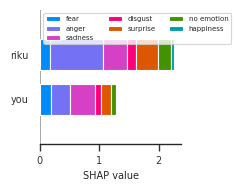

Axes(0.221514,0.257417;0.706486x0.670583)
   Names  Metric
0   Riku    0.16
1    Wei    0.22
2  Huang    0.24
3    Tom    0.26
4  Chang    0.26


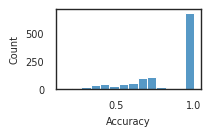

In [127]:
df_flips = evaluate('data/all.pkl', 10, 5, 'Riku')

In [112]:
tex =  df_flips[:5].to_latex(
    index=False,
    float_format="{:.2f}".format,
    caption='hello')
print(tex)

\begin{table}
\caption{hello}
\begin{tabular}{lr}
\toprule
Names & Metric \\
\midrule
Riku & 0.16 \\
Wei & 0.22 \\
Huang & 0.24 \\
Tom & 0.26 \\
Chang & 0.26 \\
\bottomrule
\end{tabular}
\end{table}

